In [1]:
!pip install paho-mqtt matplotlib
import paho.mqtt.client as mqtt
import random, time, json, sqlite3, threading
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BROKER = "test.mosquitto.org"
PORT = 1883
UNIQUE_ID = f"biotec_{random.randint(1000, 9999)}"
TOPIC_SENSORI = f"{UNIQUE_ID}/sensori/serra1"
DB_NAME = "biotec_iot.db"

def init_db():
    conn = sqlite3.connect(DB_NAME)
    conn.execute('''CREATE TABLE IF NOT EXISTS letture (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        parametro TEXT, valore REAL, timestamp DATETIME DEFAULT CURRENT_TIMESTAMP)''')
    conn.commit()
    conn.close()

init_db()
print(f"✅ Database pronto. Topic: {TOPIC_SENSORI}")

✅ Database pronto. Topic: biotec_5550/sensori/serra1


In [4]:
class IoTSystem:
    def __init__(self):
        self.sub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
        self.pub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
        self.sub.on_message = self.on_message

    def on_message(self, client, userdata, msg):
        data = json.loads(msg.payload.decode())
        conn = sqlite3.connect(DB_NAME)
        # Salviamo ogni parametro come riga separata per facilitare i grafici
        for p in ['temperature', 'humidity', 'ph', 'co2']:
            conn.execute("INSERT INTO letture (parametro, valore) VALUES (?, ?)", (p, data[p]))
        conn.commit()
        conn.close()

    def start_sub(self):
        self.sub.connect(BROKER, PORT)
        self.sub.subscribe(TOPIC_SENSORI)
        self.sub.loop_start()

    def run_publisher(self, stop_event):
        self.pub.connect(BROKER, PORT)
        while not stop_event.is_set():
            payload = {
                "temperature": round(random.uniform(20, 25), 2),
                "humidity": round(random.uniform(40, 60), 2),
                "ph": round(random.uniform(6.0, 7.5), 2),
                "co2": round(random.uniform(400, 800), 2)
            }
            self.pub.publish(TOPIC_SENSORI, json.dumps(payload))
            time.sleep(2)

system = IoTSystem()

In [5]:
stop_sim = threading.Event()
system.start_sub()
pub_thread = threading.Thread(target=system.run_publisher, args=(stop_sim,))
pub_thread.start()
print("🚀 Simulazione in corso... Lasciala girare 20 secondi e poi passa alla cella successiva.")

🚀 Simulazione in corso... Lasciala girare 20 secondi e poi passa alla cella successiva.


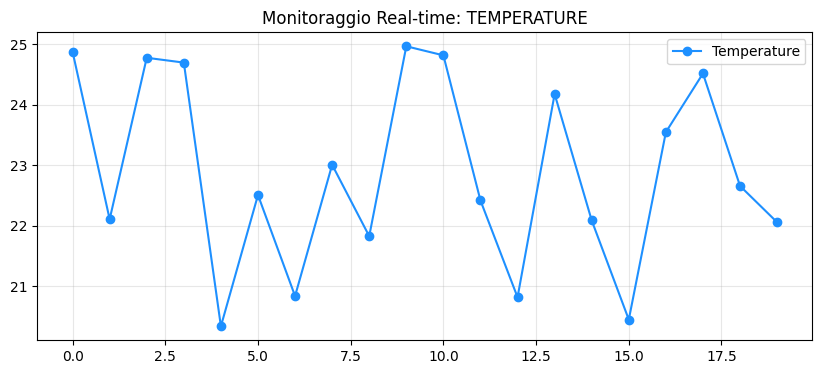

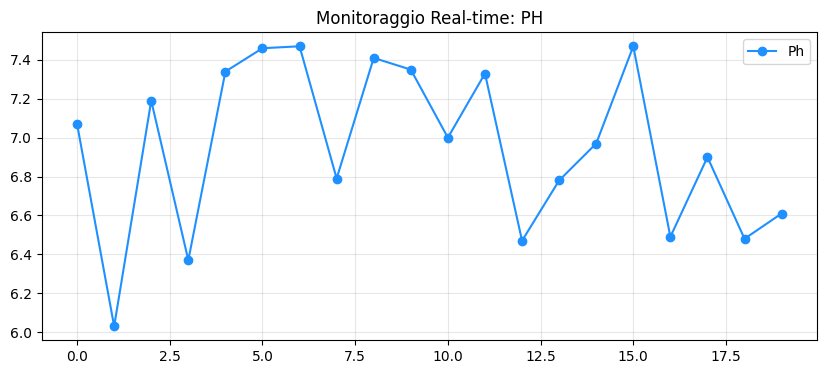

In [7]:
def plot_data(parametro):
    conn = sqlite3.connect(DB_NAME)
    query = f"SELECT id, valore FROM letture WHERE parametro='{parametro}' ORDER BY id DESC LIMIT 20"
    data = conn.execute(query).fetchall()[::-1]
    conn.close()

    if data:
        values = [d[1] for d in data]
        plt.figure(figsize=(10,4))
        plt.plot(values, marker='o', color='dodgerblue', label=parametro.capitalize())
        plt.title(f"Monitoraggio Real-time: {parametro.upper()}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show() # In un notebook, plt.show() funziona perfettamente su Codespaces!
    else:
        print("Nessun dato ancora disponibile.")

# Esempio d'uso:
plot_data('temperature')
plot_data('ph')